# Example 1: Function Fitting

In this example, we will cover how to leverage grid refinement to maximimze KANs' ability to fit functions

intialize model and create dataset

In [1]:
from kan import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# initialize KAN with G=3
model = KAN(width=[2,1,1], grid=3, k=3, seed=1, device=device)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0


Train KAN (grid=3)

In [2]:
model.fit(dataset, opt="LBFGS", steps=20);

| train_loss: 1.36e-02 | test_loss: 1.39e-02 | reg: 1.17e+01 | : 100%|█| 20/20 [00:03<00:00,  6.55it


saving model version 0.1


The loss plateaus. we want a more fine-grained KAN!

In [3]:
# initialize a more fine-grained KAN with G=10
model = model.refine(10)

saving model version 0.2


Train KAN (grid=10)

In [4]:
model.fit(dataset, opt="LBFGS", steps=20);

| train_loss: 5.92e-04 | test_loss: 6.16e-04 | reg: 1.17e+01 | : 100%|█| 20/20 [00:04<00:00,  4.87it

saving model version 0.3


The loss becomes lower. This is good! Now we can even iteratively making grids finer.

In [2]:
from kan import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device, train_num=1000)


grids = np.array([3,5,10,20,50,100])
#grids = np.array([3,10])


train_losses = []
test_losses = []
steps = 200
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k, seed=0, device=device)
    if i != 0:
        model = model.refine(grids[i])
    results = model.fit(dataset, opt="LBFGS", steps=steps)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.53e-02 | test_loss: 1.53e-02 | reg: 0.00e+00 | :  10%| | 20/200 [00:06<00:54,  3.28i


KeyboardInterrupt: 

Training dynamics of losses display staircase structures (loss suddenly drops after grid refinement)

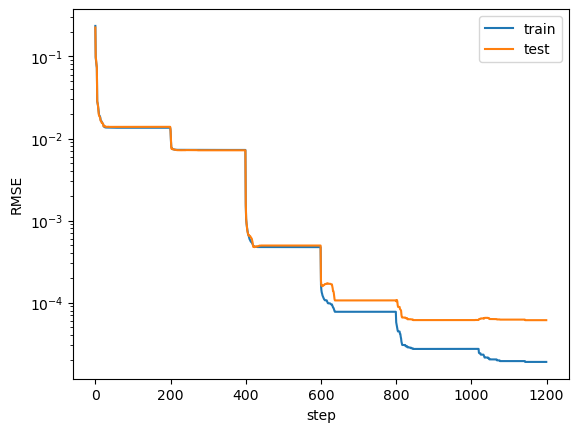

In [2]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Neural scaling laws (For some reason, this got worse than pykan 0.0. We're still investigating the reason, probably due to the updates of curve2coef)

Text(0, 0.5, 'RMSE')

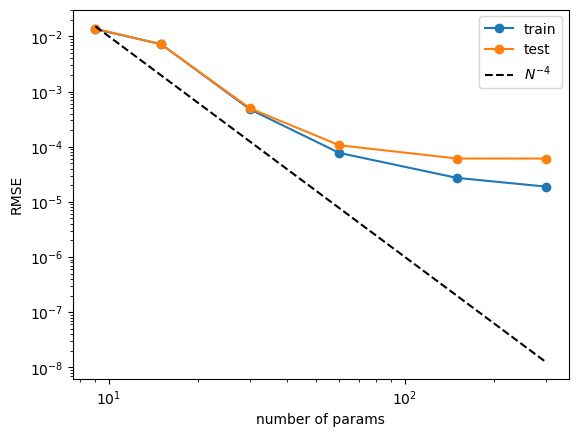

In [3]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')